# N-gram model - product description to price

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import spacy
from spacy import displacy
nlp = spacy.load("en_core_web_sm")

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LassoCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error
from sklearn.compose import TransformedTargetRegressor


C:\Users\rzp98\AppData\Local\Temp\ipykernel_38244\4036834387.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df_product = pd.read_csv('product_cleaned.csv')

In [3]:
df_product.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756077 entries, 0 to 756076
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   description  643149 non-null  object 
 1   title        756060 non-null  object 
 2   brand        750665 non-null  object 
 3   rank         756077 non-null  object 
 4   main_cat     751940 non-null  object 
 5   date         643586 non-null  object 
 6   price        293928 non-null  float64
 7   asin         756077 non-null  object 
dtypes: float64(1), object(7)
memory usage: 46.1+ MB


In [4]:
df_product.drop_duplicates(subset='asin', inplace=True)
df_product.dropna(subset=['price'], inplace=True)
df_product.dropna(subset=['description'], inplace=True)
len(df_product)

273244

In [5]:
ent_labels_to_remove = ["PERSON", "ORG", "NORP", "FAC", "GPE", "LOC", "PRODUCT", 
                          "EVENT", "WORK_OF_ART", "LAW", "LANGUAGE", "DATE", "TIME", 
                          "PERCENT", "MONEY", "QUANTITY", "ORDINAL", "CARDINAL"] # all possible entity in spacy entity recognition

def normalise_pipeline(text):
    text = text.replace("\n", " ")
    text = text.lower()
    doc = nlp(text)
    tokens = []
    ents_to_exclude_index = set()

    for ent in doc.ents:
        if ent.label_ in ent_labels_to_remove:
            ents_to_exclude_index.update(range(ent.start, ent.end))
    
    for token in doc:
        if not token.like_url and not token.like_email and not token.is_stop and not token.is_punct and token.is_alpha:
            if token.i not in ents_to_exclude_index:
                tokens.append(token.lemma_.lower())    
    return tokens

def hash_to_word(test_text):
    word = [nlp.vocab.strings[hash] for hash in test_text]
    return word

In [6]:
df_product.head(5)["description"]

0    the following camera brands and models have be...
2    a zesty tale publishers weekly garcia aguilera...
4    sex lies murder fame is brillllli f ing ant lo...
6    girl with a one track mind confessions of the ...
8    true high definition sound with cvc 6 0 noise ...
Name: description, dtype: object

In [7]:
df_product.head(5)["description"].apply(normalise_pipeline)

0    [following, camera, brand, model, test, compat...
2    [zesty, tale, publisher, create, human, charac...
4    [sex, lie, murder, fame, f, ing, ant, lolita, ...
6    [girl, track, mind, confession, seductress, door]
8    [true, high, definition, sound, cvc, noise, ca...
Name: description, dtype: object

In [8]:
df_product.value_counts("main_cat")

main_cat
Computers                                                                                                                                                                    85758
Camera & Photo                                                                                                                                                               50511
Home Audio & Theater                                                                                                                                                         40105
All Electronics                                                                                                                                                              38174
Cell Phones & Accessories                                                                                                                                                    18320
Car Electronics                                                                                 

In [9]:
df_product_small = df_product.loc[df_product["main_cat"] == "Automotive" ].sample(1000, random_state=0)

In [72]:
# X = vectorizer.fit_transform(df_product_small['description'])
# y = df_product_small['price']

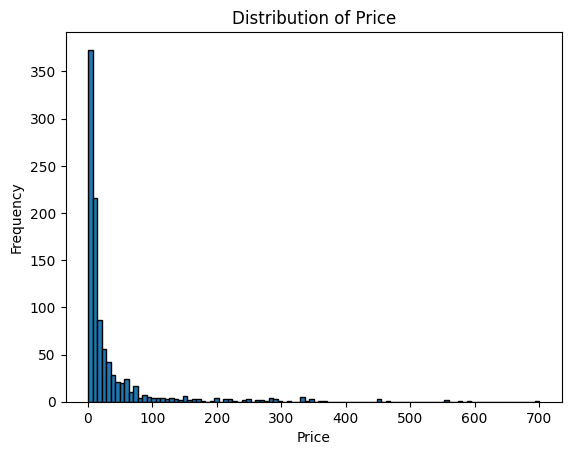

In [10]:

plt.hist(df_product_small['price'], bins=100, edgecolor='black')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.title('Distribution of Price')
plt.show()

CountVectorizer and no standarisation

c:\Users\rzp98\Desktop\TMEF\amazon review\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:639: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 23132.24770218938, tolerance: 378.90902338198333
  model = cd_fast.sparse_enet_coordinate_descent(
c:\Users\rzp98\Desktop\TMEF\amazon review\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:639: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9630.822658148849, tolerance: 378.90902338198333
  model = cd_fast.sparse_enet_coordinate_descent(
c:\Users\rzp98\Desktop\TMEF\amazon review\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:639: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44535.556010994515, tolerance: 381.66683626240007
  model = cd_fast.sparse_enet_coordinate_descent(
c:\Users\rzp98\

Mean Squared Error: 4853.478386559059
Best alpha: 1.0


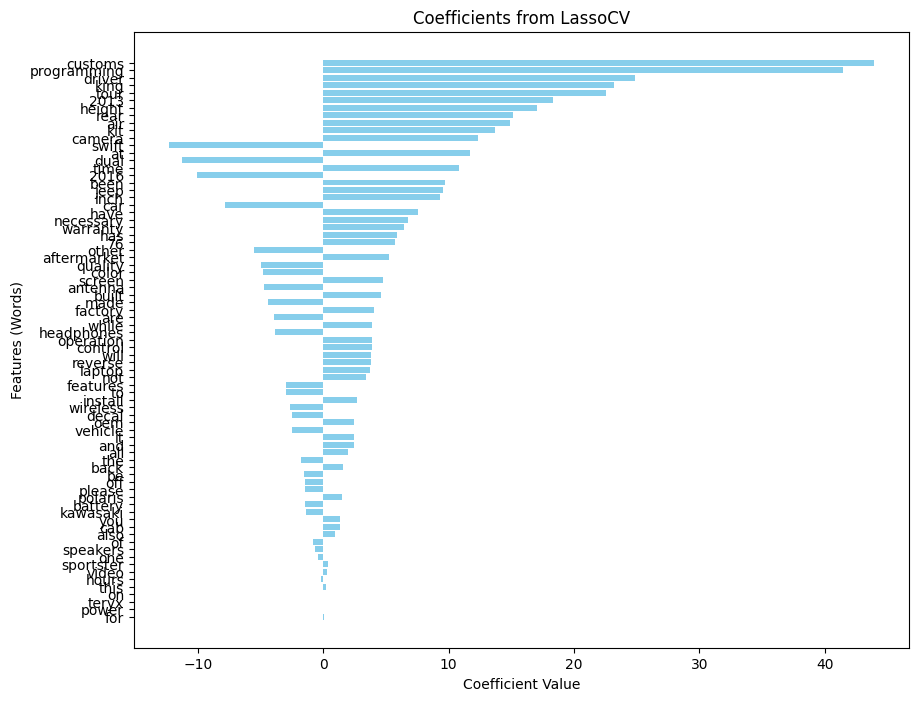

In [12]:
vectorizer = CountVectorizer()
lasso_cv = LassoCV(cv=5, random_state=1, alphas=[0.001, 0.01, 0.1, 1, 10, 100])
pipeline = make_pipeline(vectorizer, lasso_cv)
X_train, X_test, y_train, y_test = train_test_split(df_product_small["description"], df_product_small["price"], test_size=0.25, random_state=0)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')
best_alpha = pipeline.named_steps['lassocv'].alpha_
print(f'Best alpha: {best_alpha}')

coefficients = lasso_cv.coef_
feature_names = vectorizer.get_feature_names_out()
features_coefficients = zip(feature_names, coefficients)
filtered_features_coefficients = filter(lambda x: x[1] != 0, features_coefficients)
sorted_features_coefficients = sorted(filtered_features_coefficients, key=lambda x: np.abs(x[1]), reverse=True)
sorted_features, sorted_coefficients = zip(*sorted_features_coefficients)
plt.figure(figsize=(10, 8))
plt.barh(sorted_features, sorted_coefficients, color='skyblue')
plt.xlabel('Coefficient Value')
plt.ylabel('Features (Words)')
plt.title('Coefficients from LassoCV')
plt.gca().invert_yaxis()  # To display the highest coefficient at the top
plt.show()

CountVectorizer and logp transformation

In [110]:
vectorizer = CountVectorizer()
lasso_cv = LassoCV(cv=5, random_state=1, alphas=[0.001, 0.01, 0.1, 1, 10, 100])

pipeline = make_pipeline(vectorizer, lasso_cv)
transformer = TransformedTargetRegressor(regressor=pipeline, 
                                         func=np.log1p,  # log1p is used to handle the case of log(0)
                                         inverse_func=np.expm1)

X_train, X_test, y_train, y_test = train_test_split(df_product_small["description"], 
                                                    df_product_small["price"], 
                                                    test_size=0.25, 
                                                    random_state=0)

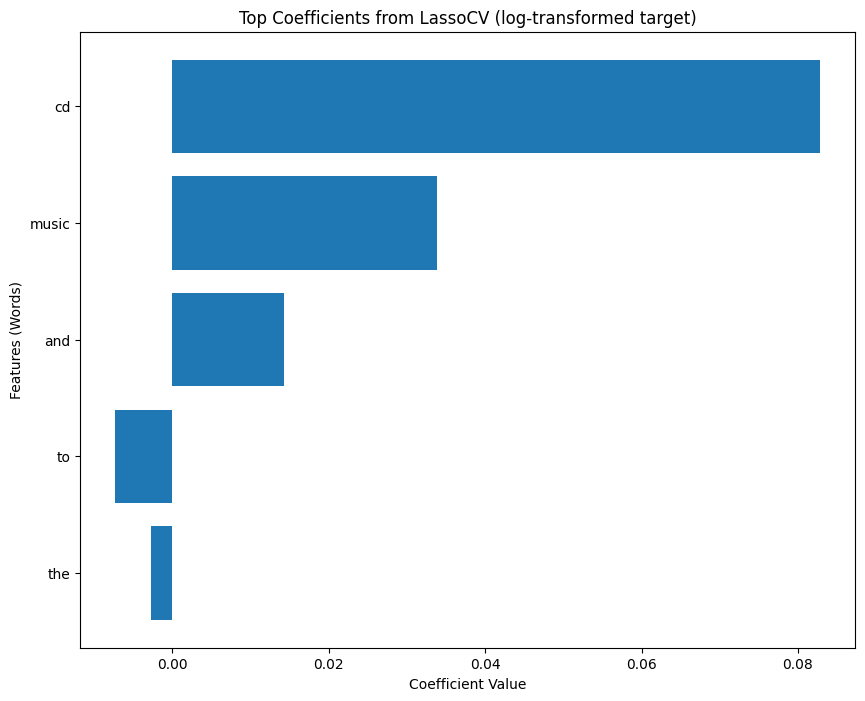

In [104]:
# Access the LassoCV model inside the pipeline
lasso_model = transformer.regressor_.named_steps['lassocv']

# Access the CountVectorizer
vectorizer = transformer.regressor_.named_steps['countvectorizer']

# Get the feature names
feature_names = vectorizer.get_feature_names_out()
coefficients = lasso_model.coef_

# Filter out non-zero coefficients for plotting
non_zero_indices = np.where(coefficients != 0)[0]
non_zero_features = feature_names[non_zero_indices]
non_zero_coefficients = coefficients[non_zero_indices]

# Sort the features by the magnitude of their coefficients
sorted_indices = np.argsort(np.abs(non_zero_coefficients))[::-1]
sorted_features = non_zero_features[sorted_indices]
sorted_coefficients = non_zero_coefficients[sorted_indices]

# Plotting
plt.figure(figsize=(10, 8))
plt.barh(sorted_features[:20], sorted_coefficients[:20])  # Plot top 20 features
plt.xlabel('Coefficient Value')
plt.ylabel('Features (Words)')
plt.title('Top Coefficients from LassoCV (log-transformed target)')
plt.gca().invert_yaxis()  # Display the highest coefficient at the top
plt.show()
